In [1]:
import  imageio
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
from matplotlib import animation, rc
from IPython.display import HTML
rc('animation', html='html5')
%matplotlib inline

vid_reader = imageio.get_reader('ropeWaveClip02.mov', 'ffmpeg')

_DO_ANIMATE_ = False # set false for faster animation of just the rope

FileNotFoundError: No such file: '/home/kaushikggg/MyStuff/MyGit/splash-activities/ropeWaveClip02.mov'

In [ ]:
def get_rope_position_of_frame(frame_rgb, infer_rope_not_found=False, smoothen=False):
    frame = np.array(Image.fromarray(frame_rgb).convert('HSV')).astype(np.float32)
    color_factor = 10
    saturation_factor=2
    frame[:, :, 0] = color_factor*frame[:, :, 0] * (np.pi/180)
    frame[:, :, 1] = saturation_factor*frame[:, :, 1]
    dist_from_yellow = np.linalg.norm(frame-np.array([color_factor*0.6457718, saturation_factor*152., 243.]), axis=2)
    rope_position = (719 - (np.argmin(dist_from_yellow, axis=0)))
    
    if infer_rope_not_found:
        deviation_from_yellow = np.min(dist_from_yellow, axis=0)
        rope_position[np.where(deviation_from_yellow > 185)] = -1
    if smoothen:
        from scipy.signal import savgol_filter
        rope_position = savgol_filter(rope_position, 51, 3)
    return rope_position

def get_rope_positions_of_video(vid_reader, infer_rope_not_found=False, smoothen=False):
    rope_positions = []
    for i, frame in enumerate(vid_reader.iter_data()):
        rope_positions.append(
            get_rope_position_of_frame(frame, infer_rope_not_found, smoothen))
        if i >= 600:
            # take the first 600 frames
            break
        
    return rope_positions

In [ ]:
rope_positions = get_rope_positions_of_video(vid_reader, infer_rope_not_found=True, smoothen=True)

In [210]:
if _DO_ANIMATE_:
    fig, axarr = plt.subplots(2, figsize=(6, 12))
    x = np.arange(1280)


    def init():
        axarr[0].axis([0, 1280, 0, 720])
        axarr[0].set_aspect(1)
        plt.tight_layout(rect=(0, 0.39, 1, 1))
        return fig,

    def animate(i):
        axarr[0].cla()
        axarr[1].cla()
        axarr[0].axis([0, 1280, 0, 720])
        axarr[0].set_aspect(1)
        plt.tight_layout(rect=(0, 0.39, 1, 1))
        axarr[0].plot(x, rope_positions[i])
        axarr[1].imshow(vid_reader.get_data(i))
        return fig,

    anim = animation.FuncAnimation(
        fig, animate, frames=len(rope_positions), init_func=init, interval=100)
else:
    # Debug mode
    fig, ax = plt.subplots()
    x = np.arange(1280)
    
    def animate(i):
        ax.cla()
        ax.plot(x, rope_positions[i])
        ax.set_title("At Frame = %d" % i)
        ax.axis([0, 1280, 0, 720])
        return fig,

    def init():
        ax.axis([0, 1280, 0, 720])
        return fig,
    
    anim = animation.FuncAnimation(fig, animate, frames=len(rope_positions), init_func=init,
                              interval=25, blit=True)

html = HTML(anim.to_html5_video())
plt.clf()
html

<Figure size 432x864 with 0 Axes>

## Numerics Solution

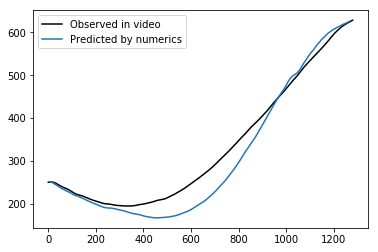

In [216]:
def bendiness(f, dx):
    result = np.zeros_like(f)

    # restricting at 'begin' and 'end'
    result[1:-1] = (1/dx**2) * (f[2:] - 2*f[1:-1] + f[:-2])
    return result

# constants
wave_speed = 1900
g = 9.81*640  # assuming the frame covers ~2 meters, dimension =  pixel/(s^2)

dt = 1/240  # since shooting at 240 fps
dx = 1.2*wave_speed*dt  # Choosing dx to maintain the CFL

x_rope = np.arange(0, 1279+dx, dx)
field = np.interp(x_rope, np.arange(1280), rope_positions[0])
velocity = np.interp(x_rope, np.arange(1280), ((rope_positions[1] - rope_positions[0])/dt))

ntimes = 30

for i in range(ntimes):
    t = i * dt
    field += dt * velocity

    # dirichlet boundary conditions
    field[0] = rope_positions[i][0]
    field[-1] = rope_positions[i][-1]

    velocity += dt * ((wave_speed**2) * bendiness(field, dx) - g)

plt.plot(rope_positions[ntimes-1], 'k', label='Observed in video')
plt.plot(x_rope, field, label='Predicted by numerics')
plt.legend()